In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error,mean_squared_log_error,r2_score
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import pickle as pkl
import joblib

DATA EXTRACTION 

In [9]:
data = pd.read_csv("male_players (legacy).csv")

testing_data = pd.read_csv("players_22-1.csv")

C:\Users\user\AppData\Local\Temp\ipykernel_45776\517933737.py:1: DtypeWarning: Columns (108) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("male_players (legacy).csv")
C:\Users\user\AppData\Local\Temp\ipykernel_45776\517933737.py:3: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  testing_data = pd.read_csv("players_22-1.csv")


DATA PREPROCESSING 

In [11]:
# len(testing_data)

In [12]:
pd.set_option('display.max_rows', None)
data.columns

Index(['player_id', 'player_url', 'fifa_version', 'fifa_update',
       'fifa_update_date', 'short_name', 'long_name', 'player_positions',
       'overall', 'potential',
       ...
       'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk',
       'player_face_url'],
      dtype='object', length=110)

In [13]:
#Droping Obviously irrelevant columns 

data.drop(['player_id','player_url','player_face_url','fifa_version','fifa_update','fifa_update_date','short_name','long_name'], axis = 1 , inplace = True)

#Per data description the columns : 
#'player_id', is a unique identifier for players
#'player_url'; a link to the players picture
#'player_face_url' ; a link to the player's face
# 'fifa_version' ; version of the fifa game 
#'fifa_update' ; which update of fifa game it is 
#fifa_update_date ; date of fifa game update
# 'short_name' and 'Long_name'
#All above attributes don't have any influence on players performance and hence not reflected in the players rating  thus we drop them
#NB : 'long_name is left for the mean time to make sens of the data as we go on but will be dropped'

In [14]:
#Check which columns have missing values :

# pd.set_option('display.max_rows', None) # use to display output in full 

# data.isna().any()

In [15]:
#Drop Columns 30% of Missing data 

null_percentage = data.isnull().mean()

# Define the threshold for acceptable null values
threshold = 0.3

# Separate columns into acceptable and unacceptable based on the threshold
acceptable_null = null_percentage[null_percentage < threshold].index.tolist()
un_acceptable_null = null_percentage[null_percentage >= threshold].index.tolist()

data = data[acceptable_null]

In [16]:
data.shape

(161583, 94)

In [17]:
#Split data into categorical and numerical for independent processing 

#Categorical columns in the data

categorical_col  = data.select_dtypes(include = ['object'])

# Numeric columns in the data

numeric_col = data.select_dtypes(include = np.number)

In [18]:
#numeric_col.head()

Process Numeric Columns

In [20]:
#Numeric Columns with null values?
null_numeric_columns = numeric_col.columns[numeric_col.isnull().any()]

In [21]:
#Impute only null numeric columns 
imp = IterativeImputer(max_iter=10, random_state=0)

imputed_numeric_col = pd.DataFrame(np.round(imp.fit_transform(numeric_col[null_numeric_columns])),
                                   columns=null_numeric_columns)

In [22]:
# Merge imputed numeric columns back into original numeric Data
numeric_col = pd.concat([numeric_col.drop(columns=null_numeric_columns), imputed_numeric_col], axis=1)

In [23]:
# numeric_col.columns

Processing Cartegorical Columns

In [25]:
#Get categorical columns with null values 

null_categorical_col = categorical_col.columns[categorical_col.isnull().any()]

In [26]:
# Impute all null cartegorical values with mode

mode_imputer = SimpleImputer(strategy='most_frequent') #Impute with mode

imputed_categorical_col = mode_imputer.fit_transform(categorical_col[null_categorical_col])
imputed_categorical_col = pd.DataFrame(imputed_categorical_col, columns = null_categorical_col)


In [27]:
#Merge imputed columns with the remaining data 
categorical_col = pd.concat([categorical_col.drop(columns=null_categorical_col), imputed_categorical_col], axis=1)

In [28]:
# categorical_col.isnull().any()

In [29]:
#Encode Categorical columns and And scale it 
scale = StandardScaler()
label_encoder = LabelEncoder()
for col in categorical_col.columns:
    categorical_col[col] = label_encoder.fit_transform(categorical_col[col].astype(str))  # Encode and convert to string

# Convert all columns to numeric for scaling
categorical_col = categorical_col.astype(float)

# Scale the data
scaled_cat_data = scale.fit_transform(categorical_col)

# Convert scaled data back to DataFrame
categorical_col= pd.DataFrame(scaled_cat_data, columns=categorical_col.columns)

Join Data Set 

In [31]:
#Join encoded data 
data = pd.concat([numeric_col,categorical_col],axis = 1)

In [32]:
#Join encoded testing data
# testing_data = pd.concat([num_col,cart_test],axis = 1)

In [33]:
data.head()

,overall,potential,age,height_cm,weight_kg,nationality_id,weak_foot,skill_moves,international_reputation,attacking_crossing,...,lb,lcb,cb,rcb,rb,gk,league_name,club_name,club_position,club_joined_date
0,93,95,27,169,67,52,3,4,5,84,...,-0.208506,-0.680472,-0.680472,-0.680472,-0.208506,-0.399360,-0.572762,-0.541519,-2.197400,-2.139727
1,92,92,29,185,80,38,4,5,5,83,...,0.024006,-0.257384,-0.257384,-0.257384,0.024006,-0.315501,-0.572762,0.782959,-0.858697,-1.935608
2,90,90,30,180,80,34,2,4,5,80,...,-0.147319,-0.632394,-0.632394,-0.632394,-0.147319,-0.504184,-1.317364,-0.534092,0.845107,-1.916313
3,90,90,32,195,95,46,4,4,5,76,...,-0.061656,-0.036224,-0.036224,-0.036224,-0.061656,-0.210678,0.337309,0.619566,0.723406,-1.519247
4,90,90,28,193,92,21,4,1,5,25,...,-1.089603,-0.959326,-0.959326,-0.959326,-1.089603,4.359634,-1.317364,-0.534092,-1.953999,-1.700009


In [34]:
# testing_data.head()

FEATURE ENGINEERING 

In [36]:
#Helper method to plot correlation matrix 
def plot_correlation(df, target_column, columns_to_plot):
    # Calculate correlations
    correlations = df[columns_to_plot].corrwith(df[target_column])

    # Sort correlations in descending order
    correlations = correlations.sort_values(ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    correlations.plot(kind='bar', color='blue')
    plt.title(f'Correlation with {target_column}')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()    

In [37]:
# Compute correlation matrix
data_corr = data.corr()

# Extract the correlation values for 'overall'
overall_corr = data_corr['overall']

# Filter columns with absolute correlation coefficient greater than 0.5
filtered_columns = overall_corr[overall_corr.abs() > 0.5].index.tolist()

# Filter the original DataFrame based on the selected columns
data = data[filtered_columns]

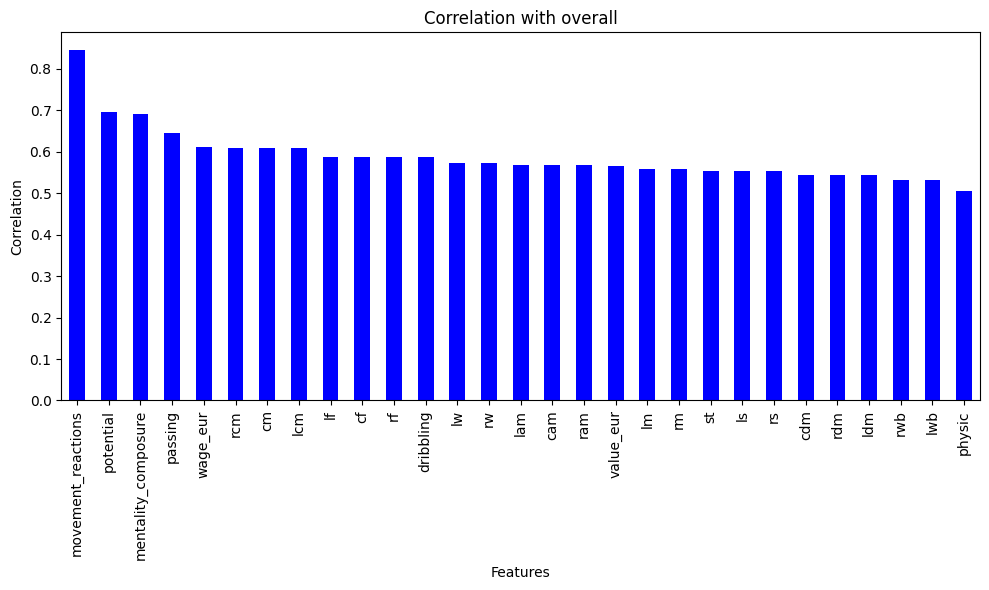

In [38]:
#Plot correlation within training data 
plot_correlation(data,'overall',data.drop('overall',axis = 1).columns.tolist())

In [39]:
#Extract the most relevant features 
#From observation and intiution using positions for overall rating would mean a bias in the player rating hence drop all player positions
data.drop(['rcm','cm','lcm','lf','cf','rf','lw','rw','lam','cam','ram','lm','rm','st','ls','rs','cdm','rdm','ldm','rwb','lwb'],axis = 1, inplace = True)

In [40]:
#Separate the data into dependent and independent 

Y = data['overall'] #dependent variable

X = data.drop('overall', axis = 1) #independent variable

#Scale independent variable
scale = StandardScaler()
scaled  = scale.fit_transform(X)

In [41]:
X = pd.DataFrame(scaled, columns = X.columns) #To make it better organized 

TRAINING MODELS 

In [43]:
#Split data for training(Get 20% of the data as testing) 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Random Forest 

In [45]:
# Training module (Random Forest)
rf = RandomForestRegressor()

In [46]:
# Perform cross-validation
cv_scores = cross_val_score(rf, X_train, Y_train, cv=5,scoring='r2')  # cv=5 for 5-fold cross-validation

# Print mean cross-validation score
print("Mean CV Score:", cv_scores.mean())

Mean CV Score: 0.9586145595078884


In [82]:
# Fit the model on the data set
rf.fit(X_train, Y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

In [83]:
#Helper method to display first ten values of the predicted and actual values 
def compare_output(actual_data, predicted_data):
    #Compare ouput in test data
    width = 6
    print("{:<{}} vs {:<{}}".format("Actual", width, "Predicted", width))
    
    print("-" * (width + width + width))
    
    #Format output
    for i in range(10):
        print("{:<{}} | {:<{}}".format(actual_data.iloc[i], width, predicted_data[i], width))

In [86]:
#Compare actual and predicted values of random forest regressor 
compare_output(Y_test, y_pred)

Actual vs Predicted
------------------
63     | 66.43 
64     | 65.29 
68     | 68.91 
63     | 63.86 
69     | 68.46 
75     | 73.7  
67     | 66.34 
78     | 77.51 
66     | 65.99 
70     | 71.44 


XGb_boost module

In [363]:
# Initialize XGBRegressor
xgb_model = xgb.XGBRegressor()

In [364]:
# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X_train, Y_train, cv = 5, scoring='r2')  # Using R2 score for evaluation

# Print mean cross-validation score
print("Mean Cross-validation R2 Score:", cv_scores.mean())

Mean Cross-validation R2 Score: 0.9543573046718613


In [365]:
# Fit the model on the data set
xgb_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred_xgb = xgb_model.predict(X_test)

Gradient Boosting regressor

In [367]:
gbr = GradientBoostingRegressor()

In [368]:
# Perform cross-validation
cv_scores = cross_val_score(gbr, X_train, Y_train, cv=5, scoring='r2')  

# print("Cross-validation R2 Scores:", cv_scores)
print("Mean Cross-validation R2 Score:", cv_scores.mean())

Mean Cross-validation R2 Score: 0.9349241219808041


In [369]:
# Fit the model on the data set
gbr.fit(X_train, Y_train)

# Predict on the test set
Y_pred_gbr = gbr.predict(X_test)

EVALUATION OF MODELS 

In [99]:
#Helper Method for Evaluation
def model_eval(model_name, pred, test) :
    print(f"""{model_name} Evaluation Metrics:
    Mean Absolute Error: {mean_absolute_error(pred, test)}
    Mean Squared Error: {mean_squared_error(pred, test)}
    Root Mean Squared Error: {np.sqrt(mean_squared_error(pred, test))}
    R2 Score: {r2_score(pred, test)}""")

In [501]:
# Evaluation metrics for Random Forest Regression model 
model_eval('Random Forest Regressor',y_pred,Y_test)

Random Forest Regressor Evaluation Metrics:
    Mean Absolute Error: 0.9488068044682366
    Mean Squared Error: 2.007130110085679
    Root Mean Squared Error: 1.416732194201035
    R2 Score: 0.9576308683357814


In [503]:
# Evaluation metrics for XGB boost regression 
model_eval('XGBoost Regression',Y_test, Y_pred_xgb)

XGBoost Regression Evaluation Metrics:
    Mean Absolute Error: 1.0917830839197533
    Mean Squared Error: 2.25049367596656
    Root Mean Squared Error: 1.5001645496299931
    R2 Score: 0.95459376369317


In [505]:
# Evaluation metrics for gradient boost algorithm 
model_eval('Gradient Boosting Regression',Y_test,Y_pred_gbr)

Gradient Boosting Regression Evaluation Metrics:
    Mean Absolute Error: 1.3405254873915502
    Mean Squared Error: 3.1700810823078442
    Root Mean Squared Error: 1.7804721515114592
    R2 Score: 0.9360400554454967


FINE TUNE BEST MODEL

Fine Tune Random Forest Model 

In [88]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],            
    'max_depth': [10, 20, None],               
    'min_samples_split': [2, 5],               
    'min_samples_leaf': [1, 2, 4],             
    'max_features': ['auto', 'sqrt'],          
    'bootstrap': [True]                  
}

In [90]:
# Initialize  GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

In [92]:
# Fit the model
grid_search.fit(X_train, Y_train)

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 666, in _validate_params
    validate

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='neg_mean_squared_error')

In [93]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [94]:
# Train the model with the best parameters
best_model_rf = RandomForestRegressor(**best_params)
best_model_rf.fit(X_train, Y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=150)

Test Improved model on Test Set from Original data set(players_22)

In [95]:
# Test improved model on the data set 
y_pred_bm = best_model_rf.predict(X_test)

In [101]:
# Random forest regression metrics of improved model
model_eval('Random Forest Regressor',y_pred_bm,Y_test)

Random Forest Regressor Evaluation Metrics:
    Mean Absolute Error: 0.9730203219986925
    Mean Squared Error: 1.931100120700397
    Root Mean Squared Error: 1.3896402846421794
    R2 Score: 0.958465155160794


In [103]:
file_path = 'C:/Users/user/OneDrive - Ashesi University/Sophomore Year Semester II/Introduction to Artificial Intelligence/Fifa_Assignment/' + best_model_rf.__class__.__name__ + '.pkl'

# Save the model using joblib
joblib.dump(best_model_rf, file_path)

['C:/Users/user/OneDrive - Ashesi University/Sophomore Year Semester II/Introduction to Artificial Intelligence/Fifa_Assignment/RandomForestRegressor.pkl']

In [105]:
def preprocess_sample(sample):
    
    # Define the threshold for acceptable null values
    threshold = 0.3
    
    # Remove columns with too many null values
    null_percentage = sample.isnull().mean()
    acceptable_null = null_percentage[null_percentage < threshold].index.tolist()
    sample = sample[acceptable_null]

    # Separate columns into categorical and numeric
    categorical_col = sample.select_dtypes(include=['object'])
    numeric_col = sample.select_dtypes(include=np.number)

    # Impute null values in numeric columns
    null_numeric_columns = numeric_col.columns[numeric_col.isnull().any()]
    imputed_numeric_col = pd.DataFrame(np.round(imp.fit_transform(numeric_col[null_numeric_columns])),
                                   columns=null_numeric_columns)
    numeric_col = pd.concat([numeric_col.drop(columns=null_numeric_columns), imputed_numeric_col], axis=1)

    # Impute null values in categorical columns
    null_categorical_col = categorical_col.columns[categorical_col.isnull().any()]
    imputed_categorical_col = pd.DataFrame(mode_imputer.fit_transform(categorical_col[null_categorical_col]), columns=null_categorical_col)
    categorical_col = pd.concat([categorical_col.drop(columns=null_categorical_col), imputed_categorical_col], axis=1)

    # Encode categorical columns and scale numeric columns
    for col in categorical_col.columns:
        categorical_col[col] = label_encoder.fit_transform(categorical_col[col].astype(str))  # Encode and convert to string

    # Convert all columns to numeric for scaling
    categorical_col = categorical_col.astype(float)

    # Scale the sample
    scaled_cat_sample = scale.fit_transform(categorical_col)

    # Convert scaled sample back to DataFrame
    categorical_col = pd.DataFrame(scaled_cat_sample, columns=categorical_col.columns)
    
    # Combine numeric and categorical columns
    sample = pd.concat([numeric_col, categorical_col], axis=1)
    
    return sample

def feature_engineering(sample):
    sample_corr = sample.corr()
    overall_corr = sample_corr['overall']  # Assuming 'overall' is a target or important feature
    filtered_col = overall_corr[overall_corr.abs() > 0.5].index.tolist()
    sample = sample[filtered_col]
    return sample

Train and Test Model Again with New data

In [108]:
#Clean testing data
data_for_test = preprocess_sample(testing_data)

In [110]:
#Feature enigeer to pick relevant columns in test data 
data_for_test = feature_engineering(data_for_test)

In [112]:
#Inherit the the features of the main data set 
data_for_test = data_for_test[data.columns]

In [114]:
print(data_for_test.columns)
print(data.shape)

Index(['overall', 'potential', 'movement_reactions', 'value_eur', 'wage_eur',
       'passing', 'dribbling', 'physic', 'mentality_composure'],
      dtype='object')
(161583, 9)


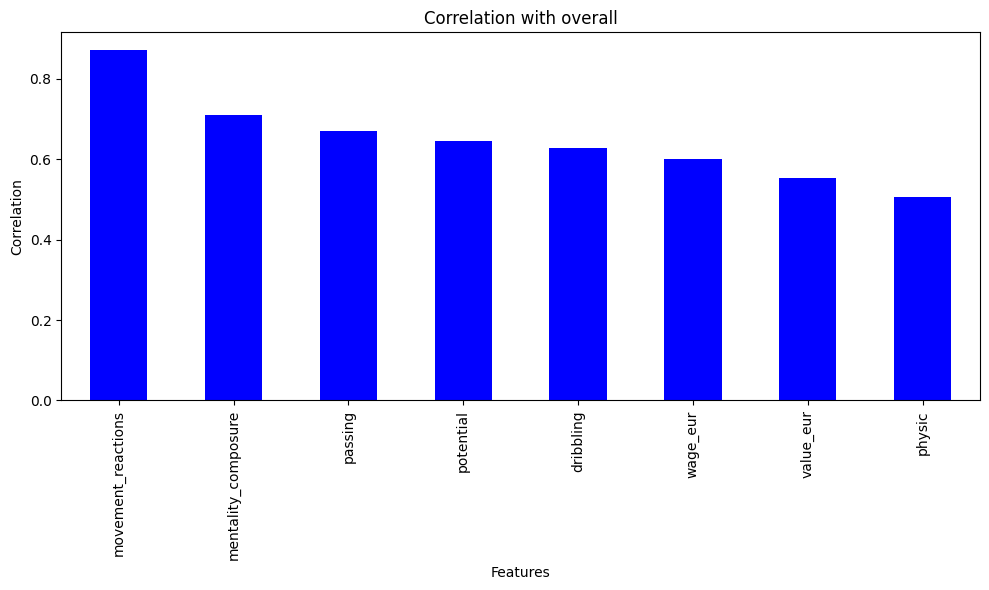

In [116]:
#Plot correlation of test data 
plot_correlation(data_for_test,'overall',data_for_test.drop('overall',axis = 1).columns.tolist())

Testing With New Data Set

In [119]:
#split data into X-test and Y-test
Y_new_test= data_for_test['overall'] #dependent variable

X_new_test = data_for_test.drop('overall', axis = 1) #independent variable

#Scale independent variable
scaled  = scale.fit_transform(X_new_test)
X_new_test = pd.DataFrame(scaled, columns = X_new_test.columns)

In [121]:
new_prediction = best_model_rf.predict(X_new_test)

In [123]:
compare_output(Y_new_test,new_prediction)

Actual vs Predicted
------------------
93     | 92.35333333333334
92     | 91.04 
91     | 90.63333333333334
91     | 91.22666666666667
91     | 90.80666666666667
91     | 88.28666666666666
91     | 91.34666666666666
90     | 85.48666666666666
90     | 88.84666666666666
90     | 89.75333333333333


In [542]:
data.head(2)

,overall,potential,movement_reactions,value_eur,wage_eur,passing,dribbling,physic,mentality_composure
0,93,95,94,100500000.0,550000.0,86.0,96.0,63.0,95.0
1,92,92,90,79000000.0,375000.0,81.0,91.0,79.0,94.0


Deploy Model 

In [540]:
# data['mentality_composure'].max()

112.0